# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load

In [ ]:
orders = pd.read_csv("order_july25.csv")
new_customers = pd.read_csv("new_customer25.csv")

orders.shape, new_customers.shape

((10000, 6), (20, 6))

# Data Quality Report (Before Cleaning)

In [ ]:
def quality_report(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "missing_count": df.isna().sum(),
        "missing_pct": (df.isna().mean()*100).round(2),
        "unique_values": df.nunique()
    })

quality_before = quality_report(orders)
quality_before

,dtype,missing_count,missing_pct,unique_values
number_past_order,float64,116,1.16,6
time_web,float64,103,1.03,171
voucher,float64,134,1.34,2
past_spend,float64,124,1.24,91
ad_channel,float64,118,1.18,4
revenue,float64,0,0.00,92


# Data Cleaning (NO ROW REMOVAL)

In [ ]:
cleaned = orders.copy()

num_cols = ["number_past_order","past_spend","time_web"]
cat_cols = ["ad_channel","voucher"]

for c in num_cols + cat_cols + ["revenue"]:
    cleaned[c] = pd.to_numeric(cleaned[c], errors="coerce")

cleaned.loc[cleaned["time_web"] <= 0, "time_web"] = np.nan
cleaned.loc[cleaned["number_past_order"] < 0, "number_past_order"] = np.nan
cleaned.loc[cleaned["past_spend"] < 0, "past_spend"] = np.nan
cleaned.loc[~cleaned["voucher"].isin([0,1]), "voucher"] = np.nan
cleaned.loc[~cleaned["ad_channel"].isin([1,2,3,4]), "ad_channel"] = np.nan

cleaned["number_past_order"].fillna(cleaned["number_past_order"].median(), inplace=True)
cleaned["past_spend"].fillna(cleaned["past_spend"].median(), inplace=True)
cleaned["time_web"].fillna(cleaned["time_web"].median(), inplace=True)
cleaned["voucher"].fillna(cleaned["voucher"].mode()[0], inplace=True)
cleaned["ad_channel"].fillna(cleaned["ad_channel"].mode()[0], inplace=True)

cleaned["voucher"] = cleaned["voucher"].astype(int)
cleaned["ad_channel"] = cleaned["ad_channel"].astype(int)
cleaned["number_past_order"] = cleaned["number_past_order"].astype(int)

/tmp/ipython-input-1512636728.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned["number_past_order"].fillna(cleaned["number_past_order"].median(), inplace=True)
/tmp/ipython-input-1512636728.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

# Data Quality Report (After Cleaning)

In [ ]:
quality_after = quality_report(cleaned)

pd.concat(
    [quality_before["missing_count"], quality_after["missing_count"]],
    axis=1,
    keys=["Before","After"]
)

,Before,After
number_past_order,116,0
time_web,103,0
voucher,134,0
past_spend,124,0
ad_channel,118,0
revenue,0,0


# Exploratory Data Visualisations

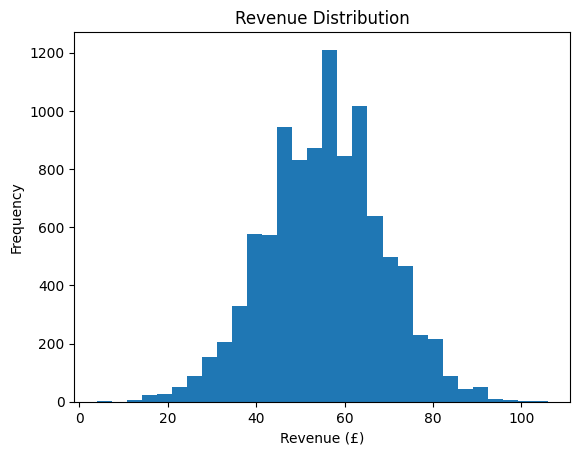

In [ ]:
plt.figure()
plt.hist(cleaned["revenue"], bins=30)
plt.title("Revenue Distribution")
plt.xlabel("Revenue (£)")
plt.ylabel("Frequency")
plt.show()

<Figure size 640x480 with 0 Axes>

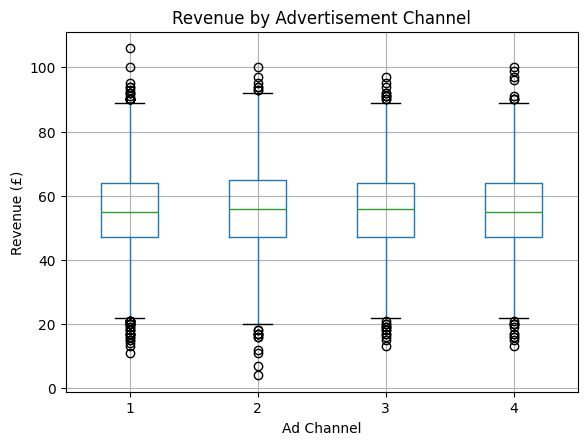

In [ ]:
plt.figure()
cleaned.boxplot(column="revenue", by="ad_channel")
plt.title("Revenue by Advertisement Channel")
plt.suptitle("")
plt.xlabel("Ad Channel")
plt.ylabel("Revenue (£)")
plt.show()


<Figure size 640x480 with 0 Axes>

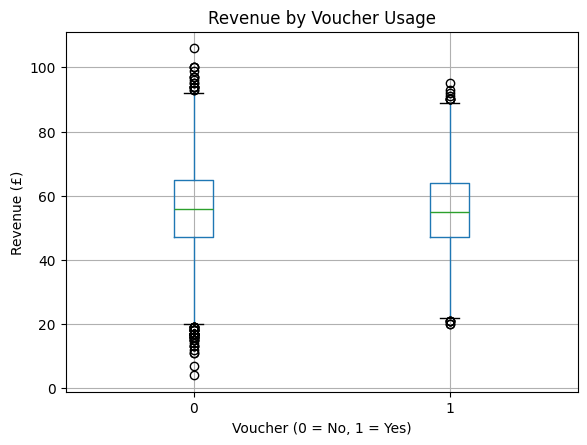

In [ ]:
plt.figure()
cleaned.boxplot(column="revenue", by="voucher")
plt.title("Revenue by Voucher Usage")
plt.suptitle("")
plt.xlabel("Voucher (0 = No, 1 = Yes)")
plt.ylabel("Revenue (£)")
plt.show()

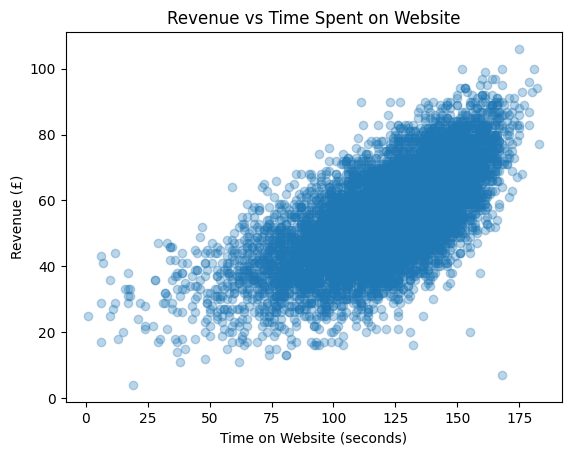

In [ ]:
plt.figure()
plt.scatter(cleaned["time_web"], cleaned["revenue"], alpha=0.3)
plt.title("Revenue vs Time Spent on Website")
plt.xlabel("Time on Website (seconds)")
plt.ylabel("Revenue (£)")
plt.show()

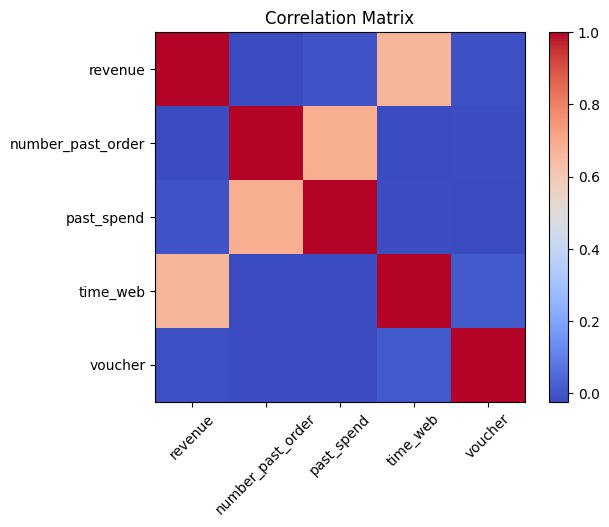

In [ ]:
corr = cleaned[["revenue","number_past_order","past_spend","time_web","voucher"]].corr()

plt.figure()
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix")
plt.show()

# Train–Test Split

In [ ]:
X = cleaned.drop(columns=["revenue"])
y = cleaned["revenue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing Pipeline

In [ ]:
num_features = ["number_past_order","past_spend","time_web"]
cat_features = ["ad_channel","voucher"]

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# Model Training & Comparison

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001, max_iter=10000),
    "Elastic Net": ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000),
    "KNN": KNeighborsRegressor(n_neighbors=15),
    "Random Forest": RandomForestRegressor(n_estimators=80, min_samples_leaf=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({"Model": name, "RMSE": rmse})

model_results = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
model_results


,Model,RMSE
0,Gradient Boosting,10.143075
1,Elastic Net,10.235062
2,Ridge Regression,10.235239
3,Lasso Regression,10.235273
4,Linear Regression,10.235293
5,KNN,10.408498
6,Random Forest,10.504389


# Model Comparison Visualisation

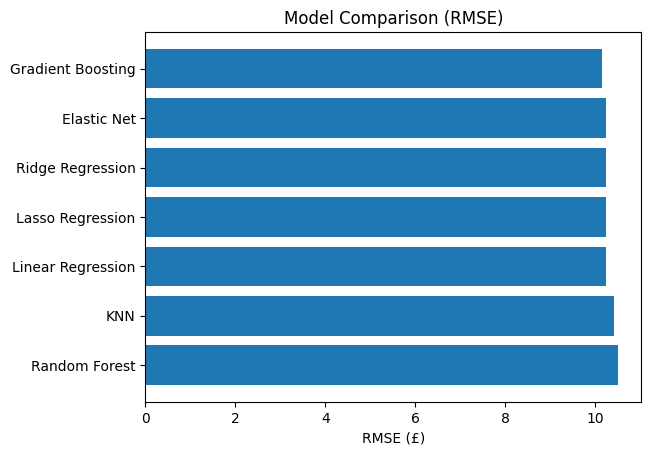

In [ ]:
plt.figure()
plt.barh(model_results["Model"], model_results["RMSE"])
plt.gca().invert_yaxis()
plt.title("Model Comparison (RMSE)")
plt.xlabel("RMSE (£)")
plt.show()


# Best Model Training (Gradient Boosting)

In [ ]:
best_model = GradientBoostingRegressor(random_state=42)

final_pipeline = Pipeline([
    ("prep", preprocess),
    ("model", best_model)
])

final_pipeline.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['number_past_order',
                                                   'past_spend', 'time_web']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ad_channel', 'voucher'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

# Best Model Diagnostics

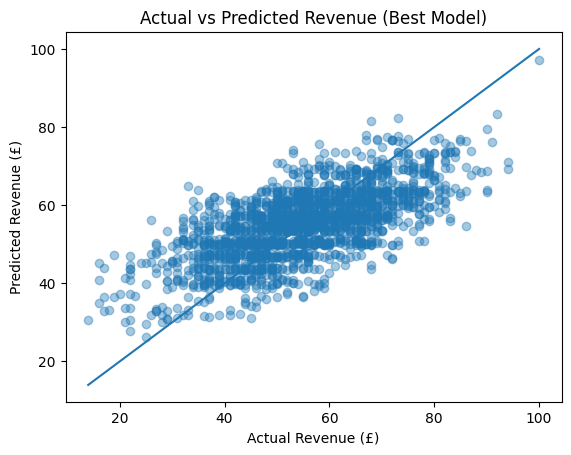

In [ ]:
#Actual vs Predicted
best_preds = final_pipeline.predict(X_test)

plt.figure()
plt.scatter(y_test, best_preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Revenue (£)")
plt.ylabel("Predicted Revenue (£)")
plt.title("Actual vs Predicted Revenue (Best Model)")
plt.show()


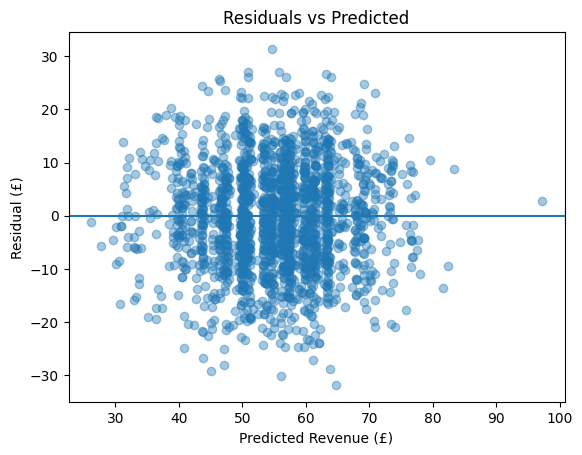

In [ ]:
# Residual Plot
residuals = y_test - best_preds

plt.figure()
plt.scatter(best_preds, residuals, alpha=0.4)
plt.axhline(0)
plt.xlabel("Predicted Revenue (£)")
plt.ylabel("Residual (£)")
plt.title("Residuals vs Predicted")
plt.show()

# Predict Revenue for New Customers

In [ ]:
X_new = new_customers.drop(columns=["order"])
predictions = final_pipeline.predict(X_new)

prediction_table = pd.DataFrame({
    "order": new_customers["order"],
    "prediction": np.round(predictions, 2)
})

prediction_table

,order,prediction
0,1,63.35
1,2,63.29
2,3,46.76
3,4,53.72
4,5,45.40
5,6,57.54
6,7,63.57
7,8,56.84
8,9,61.21
9,10,66.22
